In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
from __future__ import division
import sys
import os
sys.path.append('../')
from fastai.vision import *
from modules.basics import *
from PIL import Image, ImageDraw, ImageFont
from concurrent.futures import ProcessPoolExecutor

In [2]:
IMG_PATH, DATA_PATH

(PosixPath('/home/giles/Documents/kaggle/higgsml'), PosixPath('../data'))

# Import data

Import and convert data

In [3]:
!python ../modules/data_import.py -d {DATA_PATH} -f PRI_jet_num -r True -z True -y True

Setting PRI_lep to phi = 0
Setting PRI_tau to positve phi
Setting PRI_lep to positive eta
eta component of PRI_met not found
Converting to use_cartesian coordinates
Setting PRI_lep to phi = 0
Setting PRI_tau to positve phi
Setting PRI_lep to positive eta
eta component of PRI_met not found
Converting to use_cartesian coordinates
Training on 200000 datapoints and validating on 50000, using 30 feats:
['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_all_pt', 'PRI_jet_leading_px', 'PRI_jet_leading_py', 'PRI_jet_leading_pz', 'PRI_jet_subleading_px', 'PRI_jet_subleading_py', 'PRI_jet_subleading_pz', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz', 'PRI_lep_px', 'PRI_lep_pz', 'PRI_met_px', 'PRI_met_py', 'PRI_met_pt']
Running train
Saving fold: 

Load processed data

In [4]:
with open(DATA_PATH/'feats.pkl', 'rb') as fin:
    feats = pickle.load(fin)
cont_feats = feats['cont_feats']
cat_feats = feats['cat_feats']    
cat_maps = feats['cat_maps']  
cat_szs = feats['cat_szs']  
train_feats = cont_feats + cat_feats

In [5]:
train_fy = FoldYielder(h5py.File(DATA_PATH/'train.hdf5', "r+"), cont_feats, cat_feats)
train_fy.add_input_pipe_from_file(DATA_PATH/'input_pipe.pkl')

In [6]:
df = train_fy.get_df(inc_inputs=True); len(df); df.head()

200000 candidates loaded


/home/giles/cernbox/lumin/lumin/nn/data/fold_yielder.py:115: UserWarning: pred not found in foldfile file
  warnings.warn(f'{pred_name} not found in foldfile file')


,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,...,PRI_tau_py,PRI_tau_pz,PRI_lep_px,PRI_lep_pz,PRI_met_px,PRI_met_py,PRI_met_pt,PRI_jet_num,gen_target,gen_weight
0,0.321548,-1.380385,0.334253,0.016392,0.000000,0.00000,0.000000,0.729363,0.573708,-0.393690,...,-0.041660,-0.484103,-0.366135,1.142900,0.540935,0.054335,-0.424498,1.0,1,0.000027
1,0.190721,-1.037775,0.409675,-0.083497,1.532437,0.38749,-1.522099,0.859718,0.728218,0.212961,...,-0.958901,-0.208256,0.754199,0.075247,0.472027,-0.239053,-0.479752,2.0,1,0.000027
2,-0.506700,-0.908329,-0.259508,-0.681569,0.000000,0.00000,0.000000,0.288455,-0.196258,-0.742099,...,-0.100820,-0.519125,-0.610965,-0.850099,-0.009142,-0.202128,-1.035147,0.0,0,0.000051
3,0.000000,1.099870,-0.314020,-0.880323,0.000000,0.00000,0.000000,-0.428500,-0.759808,-0.868331,...,-0.778696,-0.374640,-0.583570,1.391731,-1.355362,-0.315227,0.488893,0.0,0,0.000176
4,0.000000,0.949728,-1.179215,-0.886682,0.000000,0.00000,0.000000,-1.541634,-0.777839,-0.894197,...,-0.658444,-0.815682,-0.668068,-0.912761,-1.266727,-0.378846,0.382093,0.0,0,0.000068


In [7]:
from lumin.optimisation.features import rf_rank_features

Optimising RF


Evalualting importances


Top ten most important features:
                         Feature  Importance
0   DER_mass_transverse_met_lep    0.238815
1                  DER_mass_MMC    0.222579
2          DER_pt_ratio_lep_tau    0.200336
4                  DER_mass_vis    0.190190
3            DER_deltar_tau_lep    0.173486
5                    DER_sum_pt    0.166243
7                      DER_pt_h    0.136675
6        DER_met_phi_centrality    0.131540
8                    DER_pt_tot    0.070944
10         DER_deltaeta_jet_jet    0.009343


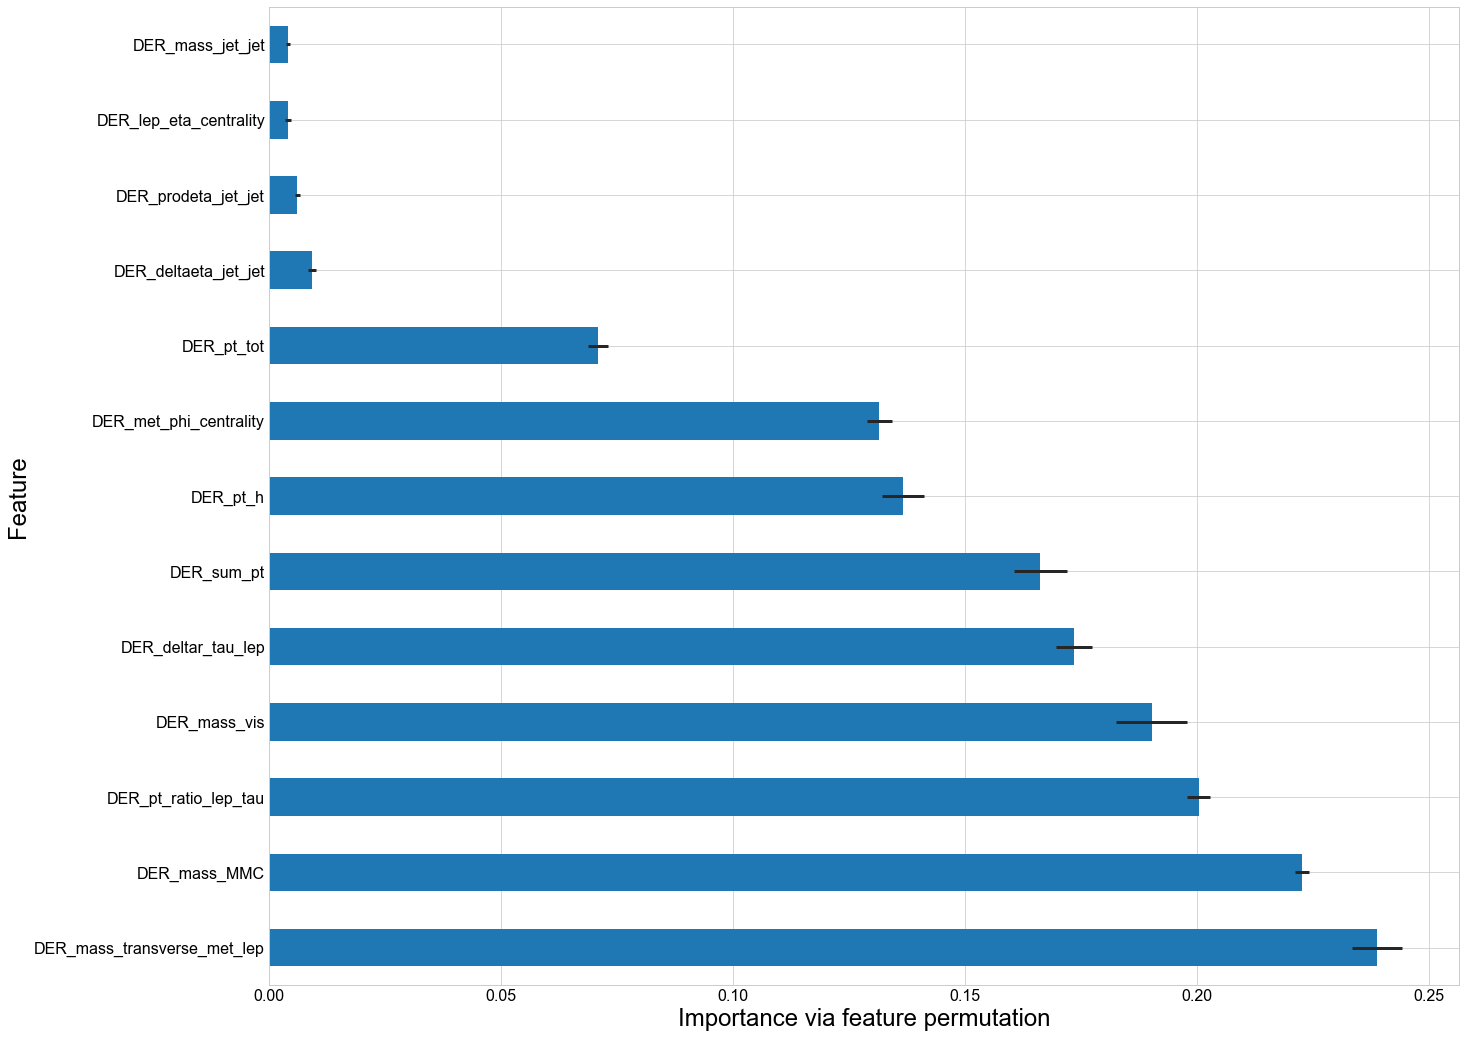


13 features found with importance greater than 0.0:
 ['DER_mass_transverse_met_lep', 'DER_mass_MMC', 'DER_pt_ratio_lep_tau', 'DER_mass_vis', 'DER_deltar_tau_lep', 'DER_sum_pt', 'DER_pt_h', 'DER_met_phi_centrality', 'DER_pt_tot', 'DER_deltaeta_jet_jet', 'DER_prodeta_jet_jet', 'DER_lep_eta_centrality', 'DER_mass_jet_jet'] 

All training features found to be important


In [8]:
der_rank = rf_rank_features(df, df, objective='classification', train_feats=[f for f in train_feats if 'DER_' in f],
                            wgt_name='gen_weight', n_rfs=5)

In [9]:
der_rank = ['DER_mass_transverse_met_lep', 'DER_mass_MMC', 'DER_pt_ratio_lep_tau', 'DER_mass_vis', 'DER_deltar_tau_lep', 'DER_sum_pt', 'DER_pt_h', 'DER_met_phi_centrality', 'DER_pt_tot', 'DER_deltaeta_jet_jet', 'DER_prodeta_jet_jet', 'DER_lep_eta_centrality', 'DER_mass_jet_jet'] 

In [10]:
pri_feats = [
    'PRI_lep_px', 'PRI_lep_pz','PRI_met_px', 'PRI_met_py', 'PRI_met_sumet', 
    'PRI_met_pt', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz', 'PRI_jet_all_pt', 'PRI_jet_num',
    'PRI_jet_leading_px', 'PRI_jet_leading_py', 'PRI_jet_leading_pz', 'PRI_jet_subleading_px', 'PRI_jet_subleading_py', 'PRI_jet_subleading_pz',
 ]
 
 

In [11]:
train_feats = der_rank + pri_feats; train_feats, len(train_feats)

(['DER_mass_transverse_met_lep',
  'DER_mass_MMC',
  'DER_pt_ratio_lep_tau',
  'DER_mass_vis',
  'DER_deltar_tau_lep',
  'DER_sum_pt',
  'DER_pt_h',
  'DER_met_phi_centrality',
  'DER_pt_tot',
  'DER_deltaeta_jet_jet',
  'DER_prodeta_jet_jet',
  'DER_lep_eta_centrality',
  'DER_mass_jet_jet',
  'PRI_lep_px',
  'PRI_lep_pz',
  'PRI_met_px',
  'PRI_met_py',
  'PRI_met_sumet',
  'PRI_met_pt',
  'PRI_tau_px',
  'PRI_tau_py',
  'PRI_tau_pz',
  'PRI_jet_all_pt',
  'PRI_jet_num',
  'PRI_jet_leading_px',
  'PRI_jet_leading_py',
  'PRI_jet_leading_pz',
  'PRI_jet_subleading_px',
  'PRI_jet_subleading_py',
  'PRI_jet_subleading_pz'],
 30)

Convert inputs to lie between 0-255

In [12]:
def sigmoid(x:np.ndarray) -> np.ndarray: return 1/(1+np.exp(-x))

In [13]:
def convert_data(df:pd.DataFrame) -> None:
    x_cont = df[cont_feats].values
    df[cont_feats] = 255*sigmoid(x_cont)*(x_cont != 0)  # NB Boolean check to ensure missing values still have value of zero
    x_cat = df[cat_feats].values
    df[cat_feats] = 255*x_cat/np.max(x_cat, axis=0)
    df[train_feats] = np.round(df[train_feats].values).astype(np.uint8)

In [14]:
df = train_fy.get_df(inc_inputs=True); len(df); df.head()
convert_data(df)

200000 candidates loaded


In [15]:
df.head()

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,...,PRI_tau_py,PRI_tau_pz,PRI_lep_px,PRI_lep_pz,PRI_met_px,PRI_met_py,PRI_met_pt,PRI_jet_num,gen_target,gen_weight
0,148,51,149,129,0,0,0,172,163,103,...,125,97,104,193,161,131,101,85,1,0.000027
1,140,67,153,122,210,152,46,179,172,141,...,71,114,173,132,157,112,97,170,1,0.000027
2,96,73,111,86,0,0,0,146,115,82,...,121,95,90,76,127,115,67,0,0,0.000051
3,0,191,108,75,0,0,0,101,81,75,...,80,104,91,204,52,108,158,0,0,0.000176
4,0,184,60,74,0,0,0,45,80,74,...,87,78,86,73,56,104,152,0,0,0.000068


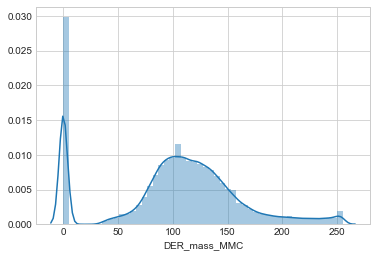

In [16]:
sns.distplot(df.DER_mass_MMC)

# Create images

In [17]:
def event2img(event:np.ndarray, size:int=224) -> PIL.Image.Image:
    arr = np.zeros([size,size], dtype=np.uint8)
    width, height = size//6, 6*size//(len(event)-1)
    for i, f in enumerate(event):
        arr[(i%6)*width:((i%6)+1)*width, (i//6)*height:((i+6)//6)*height] = f
    img = Image.fromarray(np.broadcast_to(arr.T[:,:,None], [size,size,3]), 'RGB')
    return img

CPU times: user 14.2 ms, sys: 36.1 ms, total: 50.3 ms
Wall time: 49.7 ms


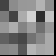

In [18]:
%%time
event2img(df[train_feats].values[1], 56)

In [19]:
font = ImageFont.truetype("arial.ttf", 13)
def event2img_desc(feats:List[str], size:int=224) -> PIL.Image.Image:
    img = Image.fromarray(np.zeros([size,size,3]), 'RGB')
    width, height = size//6, 6*size//(len(feats)-1)
    for i, f in enumerate(feats):
        f = f.split('_')
        ImageDraw.Draw(img).text(((i%6)*width, (i//6)*height), ('\n').join(f), fill=(255,255,255), font=font)
    return img

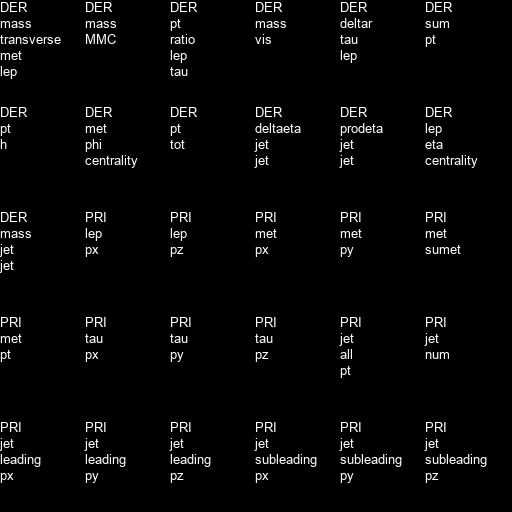

In [20]:
event2img_desc(train_feats, 512)

In [21]:
for mode in ['train', 'val', 'test']:
    os.makedirs(IMG_PATH/'pixel_squares_images'/mode, exist_ok=True)

In [22]:
def save_image(event:np.ndarray, name:Union[str, int, float], loc:Path, size:int=224) -> None:
    img = event2img(event, size)
    name = str(name)
    if '.' not in name: name += '.png'
    img.save(loc/name)

In [23]:
def proc_sample(df:pd.DataFrame, mode:str, size:int=224) -> None:
    func = partial(save_image, loc=IMG_PATH/'pixel_squares_images'/mode, size=size)
    with ProcessPoolExecutor(10) as e: e.map(func, df[train_feats].values, df.index.values)

In [24]:
SIZE=224//4

In [25]:
%%time
train_fy = FoldYielder(h5py.File(DATA_PATH/'train.hdf5', "r+"), cont_feats, cat_feats)
train_fy.add_input_pipe_from_file(DATA_PATH/'input_pipe.pkl')
train_df = train_fy.get_df(inc_inputs=True)
convert_data(train_df)
proc_sample(train_df, 'train', SIZE)

200000 candidates loaded
CPU times: user 38.1 s, sys: 5.59 s, total: 43.7 s
Wall time: 39.5 s


In [26]:
train_df.reset_index(inplace=True)
train_df.rename(columns={'index':'image_name'}, inplace=True)
train_df.to_csv(IMG_PATH/'train.csv', index=False)

In [27]:
%%time
val_fy = FoldYielder(h5py.File(DATA_PATH/'val.hdf5', "r+"), cont_feats, cat_feats)
val_fy.add_input_pipe_from_file(DATA_PATH/'input_pipe.pkl')
val_df = val_fy.get_df(inc_inputs=True)
convert_data(val_df)
proc_sample(val_df, 'val', SIZE)

50000 candidates loaded
CPU times: user 8.73 s, sys: 1.45 s, total: 10.2 s
Wall time: 9.18 s


In [28]:
val_df.reset_index(inplace=True)
val_df.rename(columns={'index':'image_name'}, inplace=True)
val_df.to_csv(IMG_PATH/'val.csv', index=False)

In [29]:
%%time
test_fy = FoldYielder(h5py.File(DATA_PATH/'testing.hdf5', "r+"), cont_feats, cat_feats)
test_fy.add_input_pipe_from_file(DATA_PATH/'input_pipe.pkl')
test_df = test_fy.get_df(inc_inputs=True)
test_df['private'] = test_fy.get_column('private')
convert_data(test_df)
proc_sample(test_df, 'test', SIZE)

550000 candidates loaded
CPU times: user 1min 59s, sys: 18.2 s, total: 2min 18s
Wall time: 2min 9s


In [30]:
test_df.reset_index(inplace=True)
test_df.rename(columns={'index':'image_name'}, inplace=True)
test_df.to_csv(IMG_PATH/'test.csv', index=False)